In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


import warnings
warnings.filterwarnings("ignore")

In [ ]:
!pip install ruptures
from ruptures.detection import KernelCPD
import ruptures as rpt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 28.8 MB/s eta 0:00:00


In [ ]:
subjects = ['proband' + str(i) for i in range(1,16)]

In [ ]:
base_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/run_walk_stand_notnormaliz.csv', index_col= 'id')
base_data["datetime"] = pd.to_datetime(base_data["datetime"])
base_data

,attr_x,attr_y,attr_z,Subject,Activity,Body_part,datetime
id,,,,,,,
1,-3.585916,9.165603,0.539892,proband1,running,head,2015-07-04 07:38:09.002
2,-3.438672,9.077616,0.606332,proband1,running,head,2015-07-04 07:38:09.021
3,-3.210625,8.965687,0.752976,proband1,running,head,2015-07-04 07:38:09.042
4,-3.034052,8.980651,0.857124,proband1,running,head,2015-07-04 07:38:09.062
5,-2.876035,9.050681,0.939126,proband1,running,head,2015-07-04 07:38:09.081
...,...,...,...,...,...,...,...
33788,-8.334216,5.079897,0.163404,proband15,running,head,2015-07-18 15:01:05.915
33789,-8.551490,4.990115,0.199317,proband15,running,head,2015-07-18 15:01:05.933
33790,-8.688558,4.890756,0.349553,proband15,running,head,2015-07-18 15:01:05.953


показываю что в наборе не только head или chest

In [ ]:
base_data.Body_part.value_counts()

thigh       1024873
waist       1024869
shin        1024833
head        1024825
chest       1024825
upperarm    1024803
forearm     1004951
Name: Body_part, dtype: int64

## Kernel Change Point Detection

Функция скользящего среднего как способ сгладить данные

In [ ]:
def rollaverage(data, window_size, time):

  data = data.groupby('Subject').resample(time, on='datetime').mean()

  data['attr_x_avg'] = data.groupby('Subject')['attr_x'].rolling(window_size).mean().values
  data['attr_y_avg'] = data.groupby('Subject')['attr_y'].rolling(window_size).mean().values
  data['attr_z_avg'] = data.groupby('Subject')['attr_z'].rolling(window_size).mean().values

  data['attr_x_avg'].fillna(data['attr_x_avg'].mean(), inplace=True)
  data['attr_y_avg'].fillna(data['attr_y_avg'].mean(), inplace=True)
  data['attr_z_avg'].fillna(data['attr_z_avg'].mean(), inplace=True)

  return data

Выберем бег с головного акселерометра.
Это значит что наиболее чувствительной будет ось z в представлении данных

In [ ]:
data = base_data[(base_data['Activity']=='running')&(base_data['Body_part']=='chest')]
data = data.drop(['Body_part','Activity'], axis=1)
data

,attr_x,attr_y,attr_z,Subject,datetime
id,,,,,
1,-1.505354,9.486425,0.623091,proband1,2015-07-04 07:38:09.003
2,-1.352125,9.406818,0.649427,proband1,2015-07-04 07:38:09.024
3,-1.404199,9.419987,0.721852,proband1,2015-07-04 07:38:09.043
4,-1.472434,9.469667,0.625485,proband1,2015-07-04 07:38:09.063
5,-1.410185,9.442732,0.565032,proband1,2015-07-04 07:38:09.085
...,...,...,...,...,...
33788,3.246537,8.705916,-2.325368,proband15,2015-07-18 15:01:05.906
33789,3.286640,8.713099,-2.194286,proband15,2015-07-18 15:01:05.926
33790,3.296816,8.760384,-2.191293,proband15,2015-07-18 15:01:05.946


In [ ]:
chest_run_roll = rollaverage(data, 2, '10S')

## Применим Kernel Change Point Detection.

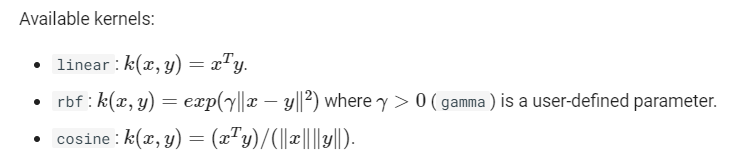

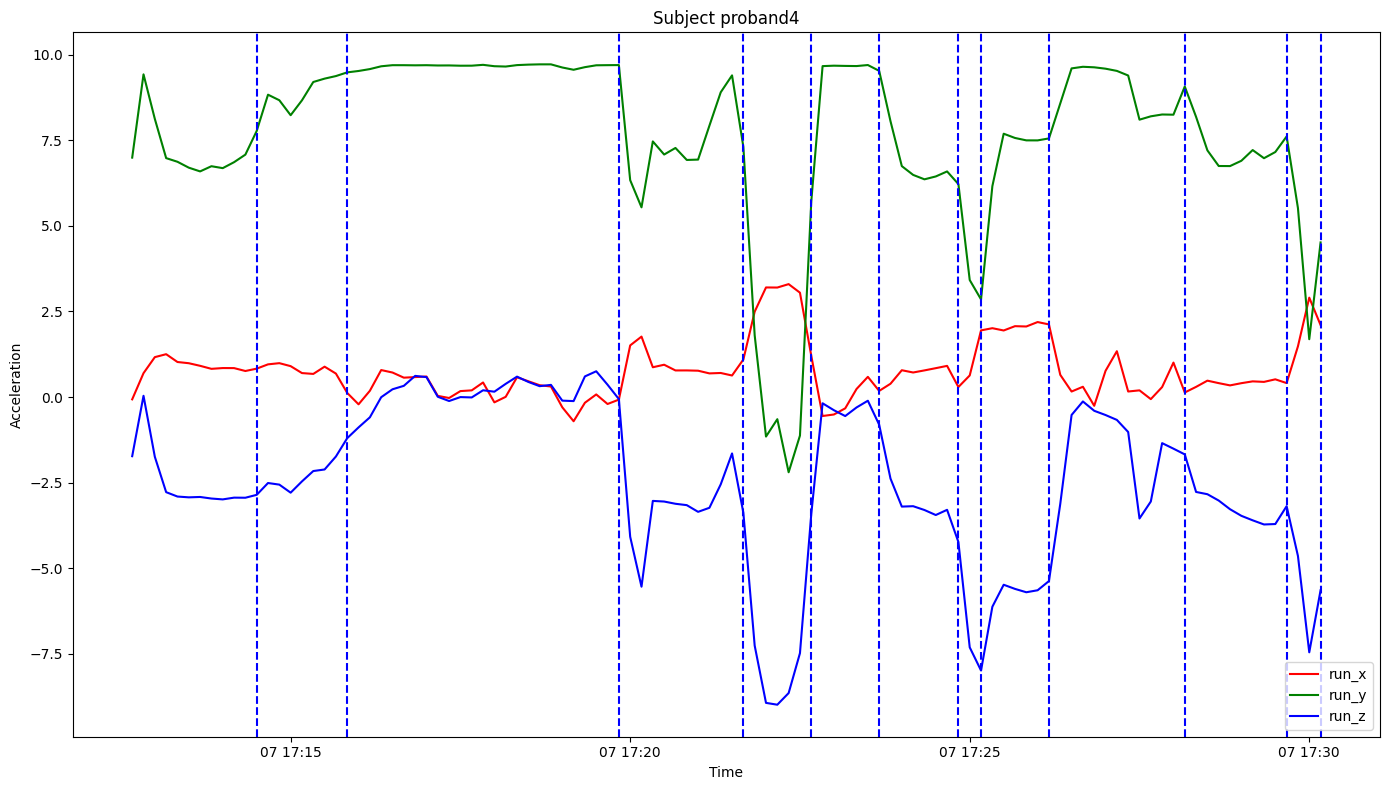

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(14, 8))

subject_data = chest_run_roll.loc['proband4'][['attr_x_avg', 'attr_y_avg', 'attr_z_avg']]

axes.plot(subject_data.index, subject_data['attr_x_avg'], color='red', label='run_x')
axes.plot(subject_data.index, subject_data['attr_y_avg'], color='green', label='run_y')
axes.plot(subject_data.index, subject_data['attr_z_avg'], color='blue', label='run_z')

axes.legend(loc='lower right')
axes.set_xlabel('Time')
axes.set_ylabel('Acceleration')
axes.set_title(f'Subject proband4')



# Выполнение KCPD
# model = KernelCPD(kernel='linear', min_size=10, jump=2)
# model.fit(subject_data.values)
# predicts = model.predict(n_bkps=None, pen=2)

# # Визуализация результатов
# for bk in predicts:
#   axes.axvline(subject_data.index[bk-1], color='red', linestyle='--', label='linear')

model = KernelCPD(kernel='rbf', min_size=1, jump=1)
model.fit(subject_data.values)
predicts = model.predict(n_bkps=None, pen=2)

# Визуализация результатов
for bk in predicts:
  axes.axvline(subject_data.index[bk-1], color='blue', linestyle='--', label='rbf')



# model = KernelCPD(kernel='cosine', min_size=10, jump=2)
# model.fit(subject_data.values)
# predicts = model.predict(n_bkps=None, pen=2)

# # Визуализация результатов
# for bk in predicts:
#   axes.axvline(subject_data.index[bk-1], color='orange', linestyle='--', label='cosine')

plt.tight_layout()
plt.show()

In [ ]:
chest_run_roll.loc['proband2'][['attr_x_avg', 'attr_y_avg', 'attr_z_avg']]

,attr_x_avg,attr_y_avg,attr_z_avg
datetime,,,
2015-07-06 07:46:30,-0.067750,6.994844,-1.728488
2015-07-06 07:46:40,0.881228,7.860999,-1.930505
2015-07-06 07:46:50,1.197233,6.200645,-2.738883
2015-07-06 07:47:00,1.206321,6.146528,-2.805860
2015-07-06 07:47:10,1.201677,6.001365,-2.900406
...,...,...,...
2015-07-06 07:56:00,-0.787230,5.713060,-2.280344
2015-07-06 07:56:10,-0.681954,5.599642,-2.311244
2015-07-06 07:56:20,-0.527938,5.636340,-2.245621


# Кластеризация и разница двух активностей

In [ ]:
df = all_data.copy(deep=True)
df = df[(df['Body_part']=='chest')&(df['Activity']=='running')&(df['Subject']=='proband4')]
# head_run_roll = rollaverage(df, 2, '10S')
# head_run_roll

In [ ]:
# нормализация времени
# proband1['datetime'] = (proband1['datetime'] - proband1['datetime'].min()) / pd.Timedelta(seconds=1)
# proband1.set_index('datetime', inplace=True)

In [ ]:
df

,attr_x,attr_y,attr_z,Subject,Activity,Body_part,datetime
id,,,,,,,
1,0.531513,9.629479,0.706290,proband4,running,chest,2015-07-07 17:12:47.414
2,0.569221,9.606135,0.830788,proband4,running,chest,2015-07-07 17:12:47.430
3,0.520140,9.681553,0.802656,proband4,running,chest,2015-07-07 17:12:47.450
4,0.521936,9.665991,0.817620,proband4,running,chest,2015-07-07 17:12:47.472
5,0.492607,9.714474,0.820613,proband4,running,chest,2015-07-07 17:12:47.494
...,...,...,...,...,...,...,...
52176,0.732027,8.873510,-2.538452,proband4,running,chest,2015-07-07 17:30:11.917
52177,0.636259,9.113529,-2.626439,proband4,running,chest,2015-07-07 17:30:11.936
52178,0.903213,9.378088,-3.271078,proband4,running,chest,2015-07-07 17:30:11.955


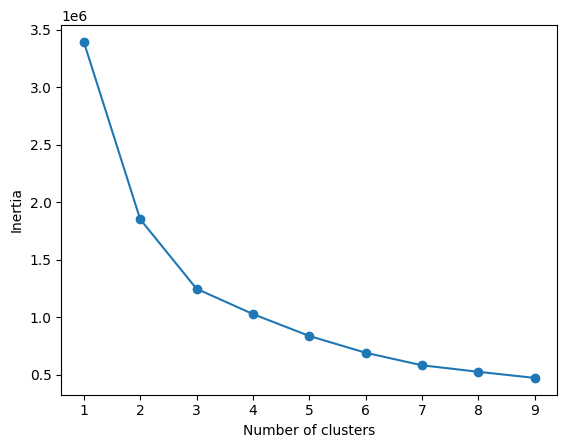

In [ ]:
X = df[['attr_x', 'attr_y', 'attr_z']]


# Определяем оптимальное количество кластеров с помощью метода локтя
inertias = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X)
    inertias.append(kmeans.inertia_)


plt.plot(range(1, 10), inertias, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

Оценивая график, возможно, точка локтя находится где-то между 3 и 6. Однако, конкретное оптимальное количество кластеров зависит от конкретного контекста и целей вашего исследования. Рекомендуется провести более детальный анализ и принять решение, исходя из специфики ваших данных и задачи кластеризации.

In [ ]:
print(inertias)

[3393397.9485265566, 1852056.1752455425, 1247649.4079118245, 1028100.0243703004, 837452.4055644139, 691636.5832163049, 582675.8123288094, 525944.9113542172, 472800.5667370587]


In [ ]:
X

,attr_x,attr_y,attr_z
id,,,
1,0.531513,9.629479,0.706290
2,0.569221,9.606135,0.830788
3,0.520140,9.681553,0.802656
4,0.521936,9.665991,0.817620
5,0.492607,9.714474,0.820613
...,...,...,...
52176,0.732027,8.873510,-2.538452
52177,0.636259,9.113529,-2.626439
52178,0.903213,9.378088,-3.271078


In [ ]:
from sklearn.metrics import adjusted_rand_score, silhouette_score, calinski_harabasz_score

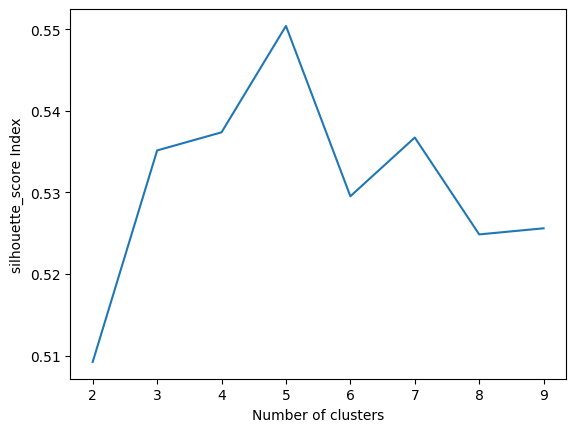

In [ ]:
results = {}
for k in range(2, 10):

    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)

    db_index = silhouette_score(X, labels)

    results.update({k: db_index})


plt.plot(list(results.keys()), list(results.values()))
plt.xlabel("Number of clusters")
plt.ylabel("silhouette_score Index")
plt.show()

In [ ]:
# Кластеризуем данные
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X)

# Добавляем метки кластеров в исходный DataFrame
X["cluster"] = kmeans.labels_


# Выводим результаты кластеризации
for i in range(n_clusters):
    cluster_data = X[X["cluster"] == i]
    print("Cluster", i)
    print("Number of samples:", len(cluster_data))
    print("Mean values of accelerometer readings:")
    print(cluster_data.iloc[:, :3].mean())


Cluster 0
Number of samples: 30294
Mean values of accelerometer readings:
attr_x    0.348557
attr_y    9.313846
attr_z   -0.946410
dtype: float64
Cluster 1
Number of samples: 5864
Mean values of accelerometer readings:
attr_x    2.753866
attr_y    0.442737
attr_z   -8.608969
dtype: float64
Cluster 2
Number of samples: 7064
Mean values of accelerometer readings:
attr_x     0.630241
attr_y    18.287833
attr_z    -5.964854
dtype: float64
Cluster 3
Number of samples: 8958
Mean values of accelerometer readings:
attr_x    1.040622
attr_y   -1.511377
attr_z   -1.020744
dtype: float64


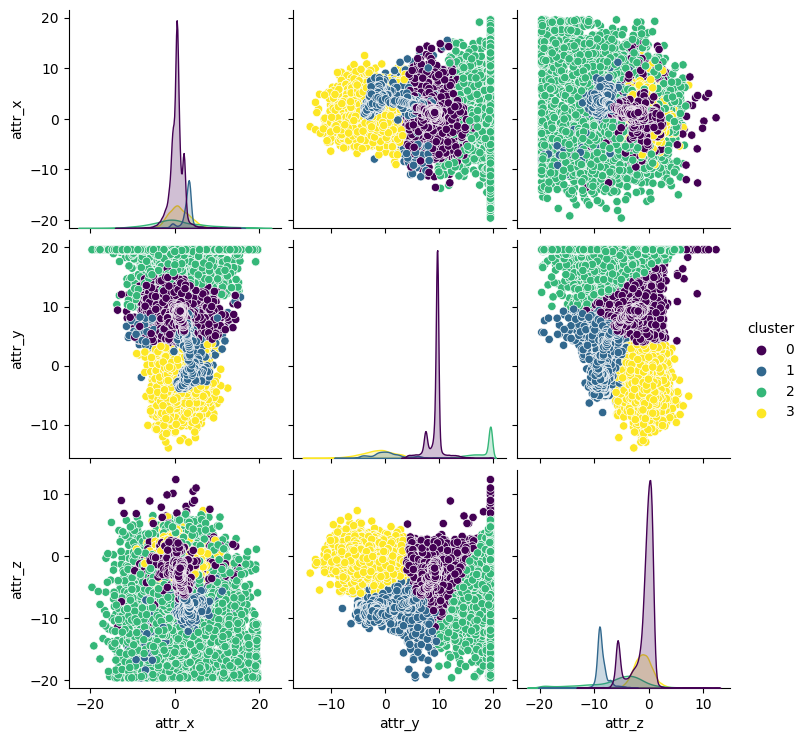

In [ ]:
# визуализация кластеров
sns.pairplot(X, vars=['attr_x', 'attr_y', 'attr_z'], hue='cluster', palette="viridis")
plt.show()

In [ ]:
# Кластеризуем данные
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X)

# Добавляем метки кластеров в исходный DataFrame
X["cluster"] = kmeans.labels_


# Выводим результаты кластеризации
for i in range(n_clusters):
    cluster_data = X[X["cluster"] == i]
    print("Cluster", i)
    print("Number of samples:", len(cluster_data))
    print("Mean values of accelerometer readings:")
    print(cluster_data.iloc[:, :3].mean())

Cluster 0
Number of samples: 2191
Mean values of accelerometer readings:
attr_x     8.363410
attr_y    18.408389
attr_z    -6.913903
dtype: float64
Cluster 1
Number of samples: 30215
Mean values of accelerometer readings:
attr_x    0.365436
attr_y    9.311677
attr_z   -0.935573
dtype: float64
Cluster 2
Number of samples: 8958
Mean values of accelerometer readings:
attr_x    1.040622
attr_y   -1.511377
attr_z   -1.020744
dtype: float64
Cluster 3
Number of samples: 4968
Mean values of accelerometer readings:
attr_x    -2.874484
attr_y    18.076219
attr_z    -5.546419
dtype: float64
Cluster 4
Number of samples: 5848
Mean values of accelerometer readings:
attr_x    2.748712
attr_y    0.418495
attr_z   -8.604302
dtype: float64


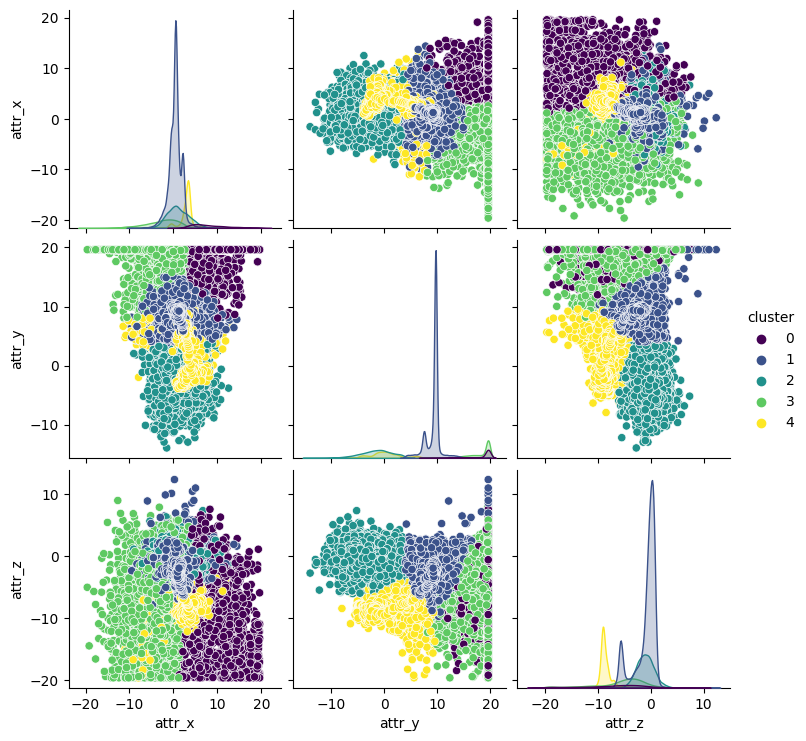

In [ ]:
# визуализация кластеров
sns.pairplot(X, vars=['attr_x', 'attr_y', 'attr_z'], hue='cluster', palette="viridis")
plt.show()

**Silhouette Score** - это мера, которая оценивает, насколько объекты внутри кластеров похожи друг на друга, и насколько они отличаются от объектов в других кластерах. Она принимает значения от -1 до 1, где 1 означает, что объекты внутри кластера очень похожи друг на друга, а -1 означает, что объекты внутри кластера очень разные. Чем выше Silhouette Score, тем лучше кластеризация.

**Calinski-Harabasz Index** - это мера, которая оценивает отношение дисперсии между кластерами к дисперсии внутри кластеров. Она принимает значения от 0 до бесконечности, где большие значения означают лучшую кластеризацию.

In [ ]:
plt.scatter(X['attr_x_avg'], X['attr_y_avg'], c = X['cluster'])

plt.xlabel('x')
plt.ylabel('y')
plt.title('Визуализация кластеров')
plt.show()

посмотрим средние показатели в данных для каждой активности

In [ ]:
all_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Диплом/acc_data.csv', index_col= 'id')
all_data["datetime"] = pd.to_datetime(all_data["datetime"])
all_data

,attr_x,attr_y,attr_z,Subject,Activity,Body_part,datetime
id,,,,,,,
1,5.616797,8.064270,0.878073,proband1,climbingdown,chest,2015-07-04 08:02:48.010
2,5.589264,8.054693,0.869095,proband1,climbingdown,chest,2015-07-04 08:02:48.032
3,5.580884,8.060080,0.908001,proband1,climbingdown,chest,2015-07-04 08:02:48.052
4,5.588067,8.033744,0.884657,proband1,climbingdown,chest,2015-07-04 08:02:48.073
5,5.583877,8.060678,0.875679,proband1,climbingdown,chest,2015-07-04 08:02:48.093
...,...,...,...,...,...,...,...
33214,9.883863,0.599748,-1.060033,proband15,walking,waist,2015-07-18 14:21:29.945
33215,9.830592,0.556053,-1.115099,proband15,walking,waist,2015-07-18 14:21:29.946
33216,9.791686,0.560842,-1.037288,proband15,walking,waist,2015-07-18 14:21:29.947


In [ ]:
df = all_data.copy(deep=True)
df = df[(df['Body_part']=='chest')&(df['Subject']=='proband4')]

for activity in df.Activity.unique():
    data = df[df["Activity"] == activity]
    print("Activity = ", activity)
    print("Number of samples:", len(data))
    print("Mean values of accelerometer readings:")
    print(data.iloc[:, :3].mean())

Activity =  climbingdown
Number of samples: 34434
Mean values of accelerometer readings:
attr_x   -0.836628
attr_y    9.584929
attr_z    0.432338
dtype: float64
Activity =  climbingup
Number of samples: 39020
Mean values of accelerometer readings:
attr_x    1.097907
attr_y    9.225524
attr_z   -2.178155
dtype: float64
Activity =  jumping
Number of samples: 4296
Mean values of accelerometer readings:
attr_x    0.251567
attr_y    5.691209
attr_z   -0.551928
dtype: float64
Activity =  lying
Number of samples: 33787
Mean values of accelerometer readings:
attr_x   -2.365621
attr_y    1.158142
attr_z    8.527425
dtype: float64
Activity =  running
Number of samples: 52180
Mean values of accelerometer readings:
attr_x    0.775810
attr_y    7.673365
attr_z   -2.499676
dtype: float64
Activity =  sitting
Number of samples: 31820
Mean values of accelerometer readings:
attr_x    0.118043
attr_y    9.440830
attr_z    2.087471
dtype: float64
Activity =  standing
Number of samples: 30241
Mean values o

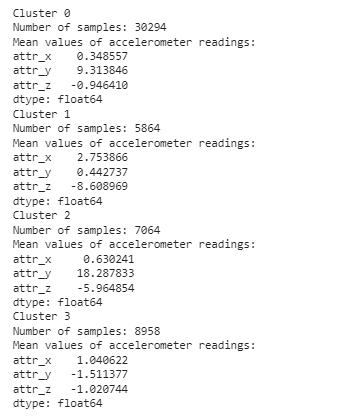

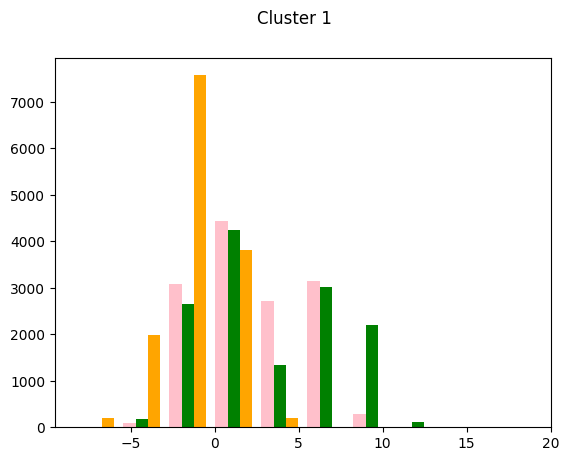

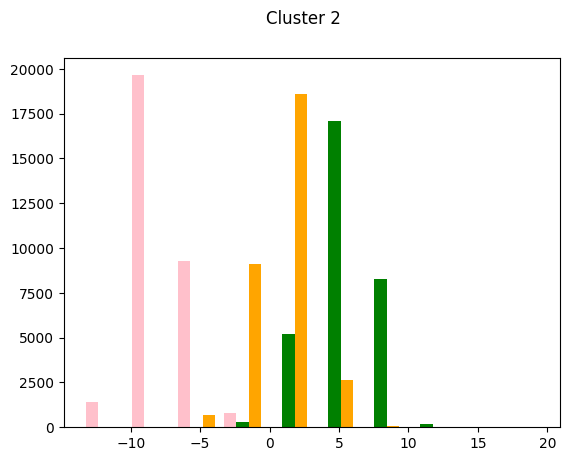

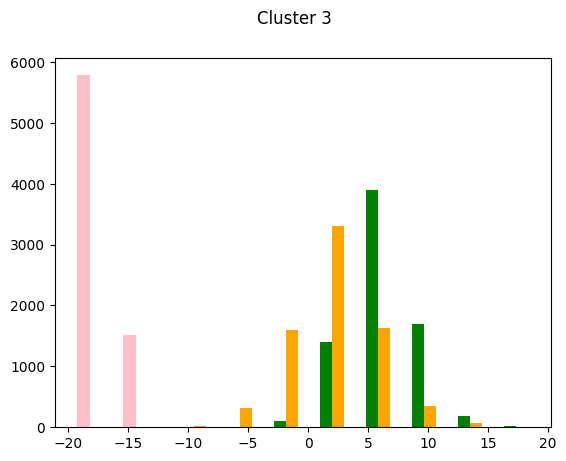

In [ ]:
colors = ['pink', 'green', 'orange']

for i in range(3):
    cluster_data = X[X['cluster'] == i]


    plt.hist(cluster_data[['attr_x','attr_y', 'attr_z']], color=['pink', 'green', 'orange'])

    plt.suptitle('Cluster ' + str(i+1))
    plt.show()



## Разница

In [ ]:
data = base_data.copy(deep=True)
data = data[data['Body_part']=='head']
data = data.drop('Body_part', axis=1)
data

,attr_x,attr_y,attr_z,Subject,Activity,datetime
id,,,,,,
1,-3.585916,9.165603,0.539892,proband1,running,2015-07-04 07:38:09.002
2,-3.438672,9.077616,0.606332,proband1,running,2015-07-04 07:38:09.021
3,-3.210625,8.965687,0.752976,proband1,running,2015-07-04 07:38:09.042
4,-3.034052,8.980651,0.857124,proband1,running,2015-07-04 07:38:09.062
5,-2.876035,9.050681,0.939126,proband1,running,2015-07-04 07:38:09.081
...,...,...,...,...,...,...
33788,-8.334216,5.079897,0.163404,proband15,running,2015-07-18 15:01:05.915
33789,-8.551490,4.990115,0.199317,proband15,running,2015-07-18 15:01:05.933
33790,-8.688558,4.890756,0.349553,proband15,running,2015-07-18 15:01:05.953


In [ ]:
data = data[(data['Subject']=='proband4')]

In [ ]:
data.Activity.value_counts()

running    52174
walking    31033
Name: Activity, dtype: int64

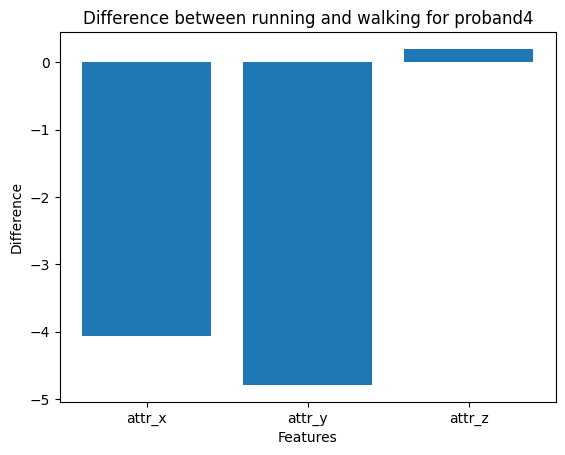

In [ ]:
# Группируем данные по субъекту
groups = data.groupby('Subject')

# Применяем кластеризацию к каждой группе отдельно
for subject, group in groups:
    X = group[['attr_x', 'attr_y', 'attr_z']]
    y = group['Activity']

    # Визуализация результатов для каждого субъекта
    running_mean = X[y == 'running'].mean()
    walking_mean = X[y == 'walking'].mean()


    plt.figure()
    plt.bar(['attr_x', 'attr_y', 'attr_z'], running_mean - walking_mean)
    plt.title(f'Difference between running and walking for {subject}')
    plt.xlabel('Features')
    plt.ylabel('Difference')
    plt.show()

### графики плотности распределения значений для ходьбы и бега. Разница

In [ ]:
data = base_data.copy(deep=True)
data = data[data['Body_part']=='head']
data = data.drop('Body_part', axis=1)
data = data[(data['Subject']=='proband1')]

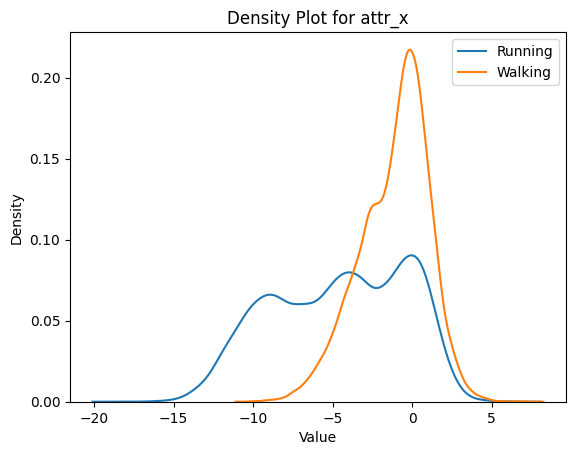

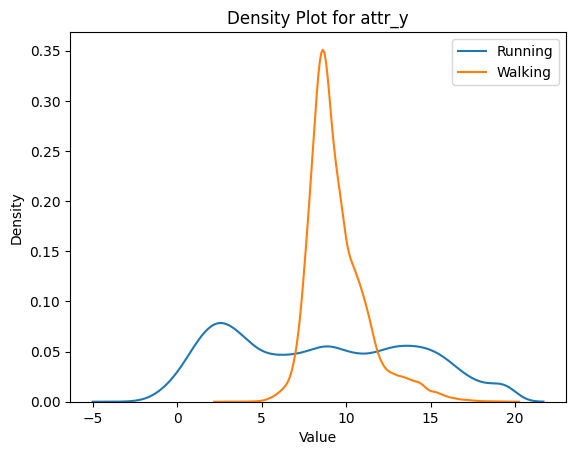

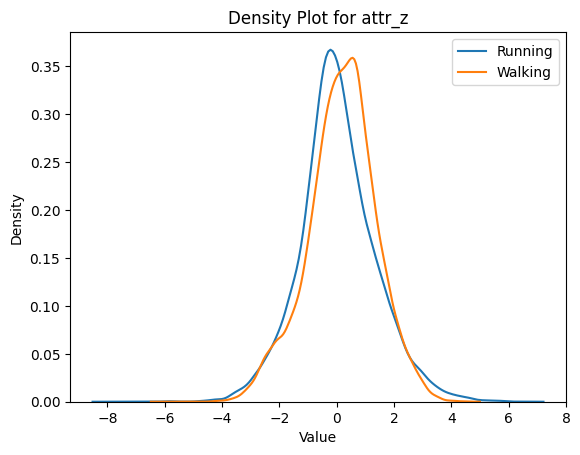

In [ ]:


running_data = data[data['Activity'] == 'running'][['attr_x', 'attr_y', 'attr_z']]
walking_data = data[data['Activity'] == 'walking'][['attr_x', 'attr_y', 'attr_z']]


sns.kdeplot(running_data['attr_x'], label='Running')
sns.kdeplot(walking_data['attr_x'], label='Walking')
plt.title('Density Plot for attr_x')
plt.legend()
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()

sns.kdeplot(running_data['attr_y'], label='Running')
sns.kdeplot(walking_data['attr_y'], label='Walking')
plt.title('Density Plot for attr_y')
plt.legend()
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()

sns.kdeplot(running_data['attr_z'], label='Running')
sns.kdeplot(walking_data['attr_z'], label='Walking')
plt.title('Density Plot for attr_z')

plt.legend()
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()